In [185]:
import pandas as pd 
import numpy as np 
import pyarrow 

import os 
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from pylab import rcParams
from datetime import datetime
from load_data import *  

In [6]:
os.chdir(r'C:\Users\Darya\Documents\Github\DS4A')

In [7]:
from const import WEEK_IDX_RANGE, DATES_FROM_WEEK_IDX

In [193]:
data = load_combined_raw_data()

In [195]:
add_dates_start_end_inplace(data)

add_age_inplace(data)
add_mental_vars_inplace(data)

## Expences 

##### Variables to explore

- Food
    - WHEREFREE1-7  - where they got food from 
    - TSPNDFOOD - money spent on food to cook 
    - TSPNDPRPD - money spent on prepared meals 
    - FREEFOOD - if there were foodstamps
- Housing 
    - TENURE - whether the house is rented or owned 
    - MORTLMT - whether the mortgage has been paid 
    - MORTCONF - confidence to pay mortgage next month 
- Employment 
    - WRKLOSS - whether the respondent lost their job 
    - EXPCTLOSS - whether the respondent expects to lose their job
    - ANYWORK - employment status the last 7 days 
    - KINDWORK - eployer type: government, private company, nonprofit, self-employed, family business
    - RSNNOWRK - reason to not work 
    - UNEMPPAY - whether paid while being unemployed 
- Economic Impact Payment
    - EIP - 
    - EIPSPEND - 
- Other 
    - INTRNT1-3 - internet services 
    - HEALTHINS1-8 - health insurance 1-8

In [8]:
datafiles_names = ['pulse2020_puf_%s.csv'%('0' + str(i)) if i < 10 else 'pulse2020_puf_%s.csv'%str(i) for i in range(1, 14)]

In [325]:
total_num = data.groupby('WEEK')['SCRAM'].count().values

### Food

In [9]:
def get_col_list(col_name, num):
    return [col_name + str(i) for i in range(1, num+1)]

#### WHEREFREE

We first explore how many non-N/A values there are. 

In [10]:
whereFree = get_col_list('WHEREFREE', 7)

In [119]:
def count_values_acros_dfs(col_list, datafiles_names=datafiles_names):
    vals = []
    for d in datafiles_names: 
        df = pd.read_csv(d)
        try:
            col_df = df[col_list]
            for col in col_list:
                val_counts, val_inds = col_df[col].value_counts().values, col_df[col].value_counts().index
                val_dict = {'DF':d.split('.')[0].split('_')[-1], 'Column_Name':col}
                val_dict.update({str(val_inds[i]):val_counts[i] for i in range(len(val_inds))})
                vals.append(val_dict)
        except: 
            continue
        del df
    df =  pd.DataFrame(columns=vals[0].keys())
    return df.append(vals, ignore_index=True)

In [32]:
def count_fract_of_1(df): 
    df['-88 or -99'] = df['-88'] + df['-99']
    df.drop(['-88', '-99'], 1, inplace = True)
    df['1'] = df['1'] / (df['1'] + df['-88 or -99'])
    df['-88 or -99'] = 1. - df['1']

In [12]:
where_df = count_values_acros_dfs(whereFree, datafiles_names=datafiles_names)

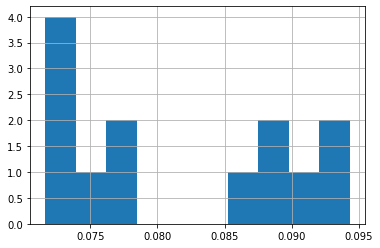

In [23]:
where_df.groupby('DF')['1'].sum().hist()

Verdict: because there are too few non-N/A values, we should drop all 7 columns. 

In [47]:
#data.drop(whereFree, 1, inplace = True)

#### INTRNT

In [24]:
intrnt = get_col_list('INTRNT', 3)

In [30]:
intrnt_df = count_values_acros_dfs(intrnt, datafiles_names=datafiles_names)

In [33]:
count_fract_of_1(intrnt_df)

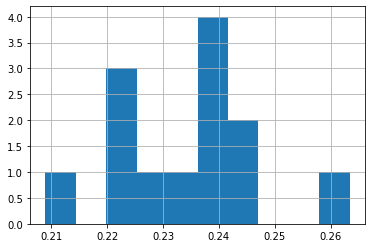

In [35]:
intrnt_df.groupby('DF')['1'].sum().hist()

In [41]:
intrnt_df_grouped = pd.DataFrame(intrnt_df.groupby(['DF', 'Column_Name'])['1'].sum()).reset_index() #.hist()

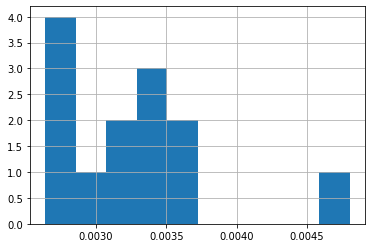

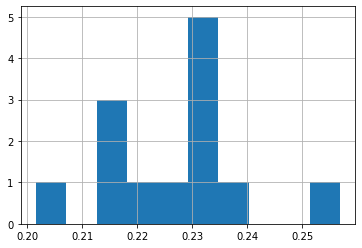

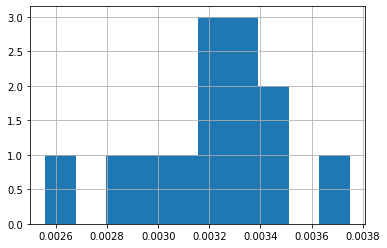

In [45]:
for c in intrnt:
    intrnt_df[intrnt_df['Column_Name'] == c]['1'].hist()
    plt.show()

We should make internet a binary variable. 

#### Health insurance 

In [50]:
hlthins = get_col_list('HLTHINS', 8)

In [51]:
hlthins_df = count_values_acros_dfs(hlthins, datafiles_names=datafiles_names)

In [52]:
count_fract_of_1(hlthins_df)

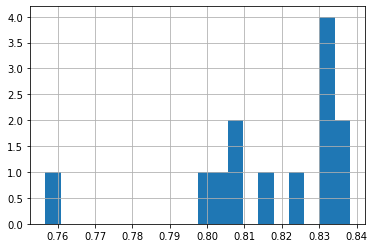

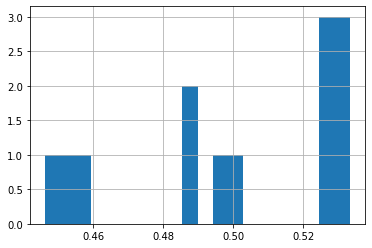

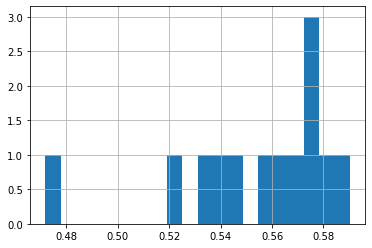

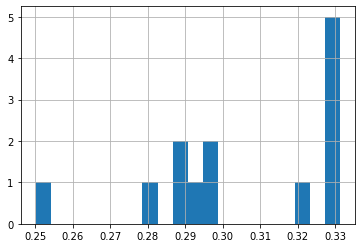

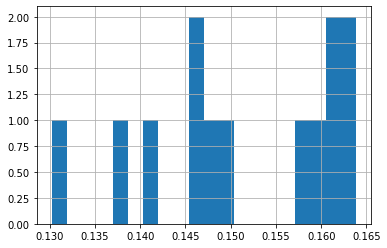

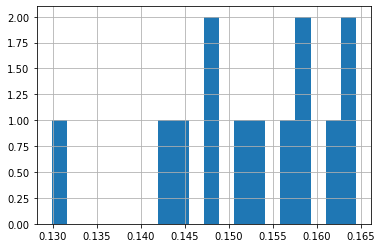

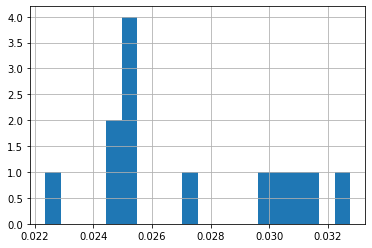

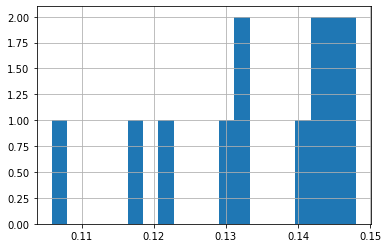

In [58]:
for c in hlthins:
    hlthins_df[hlthins_df['Column_Name'] == c]['1'].hist(bins = 20)
    plt.show()

We should keep the columns that have more than 20% of informative samples. Thus, only columns 1-4.  

In [60]:
## TODO: finish

### Housing 

### Tenure 

1) Owned free and clear?

2) Owned with a mortgage or loan (including home equitly loans)?

3) Rented?

4) Occupied without payment of rent?

In [96]:
tenure_df = count_values_acros_dfs(['TENURE'], datafiles_names=datafiles_names) 

In [97]:
for col in [str(i) for i in np.arange(1, 5)]:
    tenure_df[col] = tenure_df[col].astype(int)

In [99]:
total_num = tenure_df.sum(axis=1).values

In [100]:
tenure_df.drop(['-88', '-99'], 1, inplace=True)

In [110]:
for i in np.arange(len(tenure_df)):
        tenure_df.iloc[i, 2:] = tenure_df.iloc[i, 2:]/total_num[i]

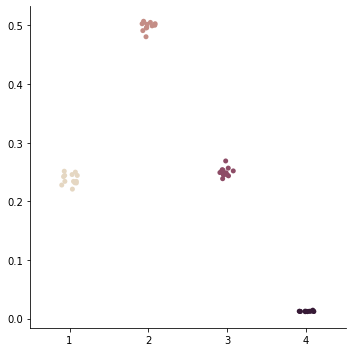

In [111]:
sns.catplot(data = tenure_df[[str(i) for i in np.arange(1, 5)]], palette="ch:.25")

So more than a half of the respondents own their tenure with a mortgage or a loan. Let's look into statistics on whether they were able to pay them. 

#### Mortgage

1) Yes

2) No

3) Payment was deferred

In [128]:
mort = count_values_acros_dfs(['MORTLMTH'], datafiles_names=datafiles_names)

In [126]:
def preprocess_df(df, num_col):
    for col in [str(i) for i in np.arange(1, num_col+1)]:
        df[col] = df[col].astype(int)
    total_num = df.sum(axis=1).values
    df.drop(['-88', '-99'], 1, inplace=True)
    for i in np.arange(len(df)):
        df.iloc[i, 2:] = df.iloc[i, 2:]/total_num[i]

In [129]:
preprocess_df(mort, 3)

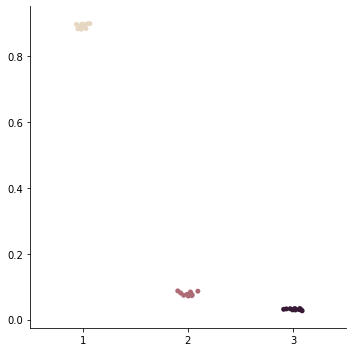

In [131]:
sns.catplot(data = mort[[str(i) for i in np.arange(1, 4)]], palette="ch:.25")

So the majority were able to pay their mortgage. Let's look at that as a time series. 

In [132]:
mort_ds_agg = pd.DataFrame()
for ds in datafiles_names: 
    data = pd.read_csv(ds)
    try:
        ds = data[['MORTLMTH', 'WEEK', 'EST_ST']]
    except: 
        ds = data[['WEEK', 'EST_ST']]
    mort_ds_agg = mort_ds_agg.append(ds) 

In [133]:
mort_df = pd.DataFrame(mort_ds_agg[mort_ds_agg['MORTLMTH'] == 1.0].groupby(['EST_ST', 'WEEK'])['MORTLMTH'].count()).reset_index()

In [156]:
mort_sums = mort_df.groupby('WEEK')['MORTLMTH'].sum()

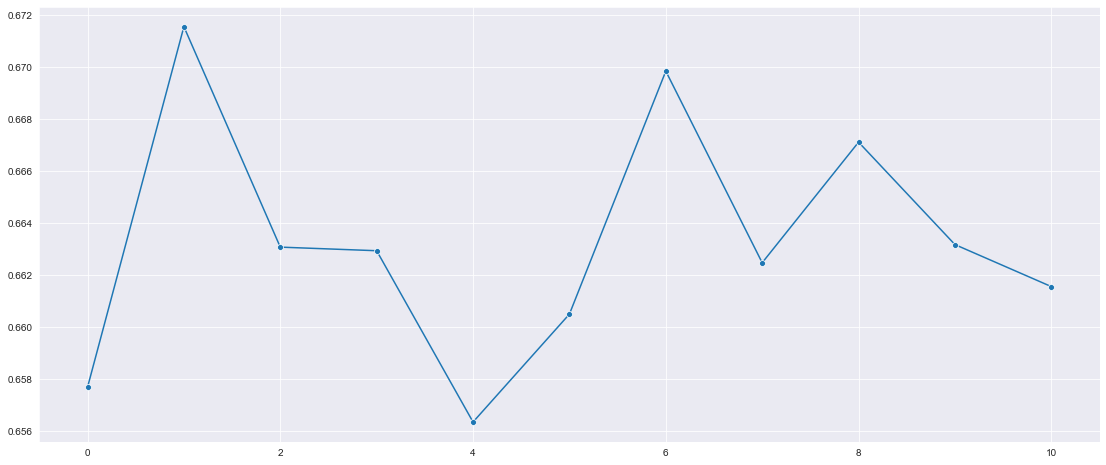

In [173]:
sns.lineplot(data = np.array([mort_sums.values[i]/total_num[i] for i in range(1, len(mort_sums))]), marker="o")

In [135]:
agg_df_by_state = pd.DataFrame({i:mort_df[mort_df['EST_ST'] == i][['MORTLMTH']].values.flatten() for i in mort_df['EST_ST'].unique()})

In [139]:
for i in range(len(agg_df_by_state)):
    agg_df_by_state.iloc[i, :] = agg_df_by_state.iloc[i, :]/total_num[i]

Text(0, 0.5, 'Fraction of people who were able to pay the mortgage by state')

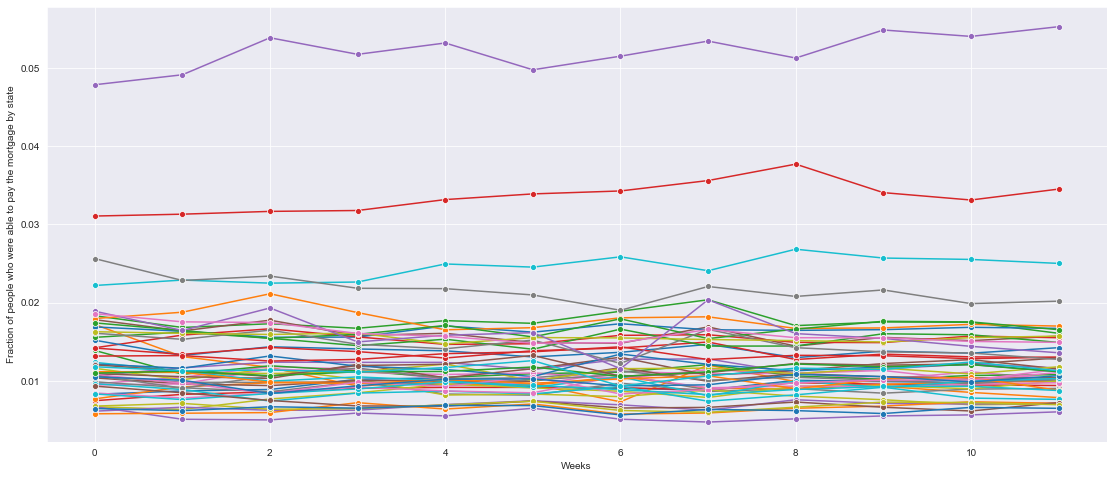

In [142]:
rcParams['figure.figsize'] = 19,8
sns.set_style("darkgrid")
for i in range(len(agg_df_by_state.columns)):
    sns.lineplot(data = agg_df_by_state.iloc[:,i], marker="o")
plt.xlabel("Weeks")
plt.ylabel("Fraction of people who were able to pay the mortgage by state")
#plt.legend()

In [174]:
## TODO: find correlation between the location of the state and this variable

### Confidence to pay mortgage next month 

1) No confidence

2) Slight confidence

3) Moderate confidence

4) High confidence 

5) Payment is/will be deferred

In [225]:
mortconf_df = pd.DataFrame(data[['WEEK', 'MORTCONF']].groupby(['MORTCONF', 'WEEK'])['MORTCONF'].count())

In [227]:
mortconf_df.columns = ['MORTCONF_count']

In [228]:
mortconf_df = mortconf_df.reset_index()

In [261]:
mortconf_dict = {str(i): mortconf_df.loc[mortconf_df['MORTCONF'] == i, 'MORTCONF_count'].values for i in range(1, 6)}
mortconf_dict['Week'] = np.arange(1, 14)

In [263]:
mortconf_df_week = pd.DataFrame(mortconf_dict)

In [265]:
for i in range(len(mortconf_df_week)):
    mortconf_df_week.iloc[i, :] = mortconf_df_week.iloc[i, :]/total_num[i]

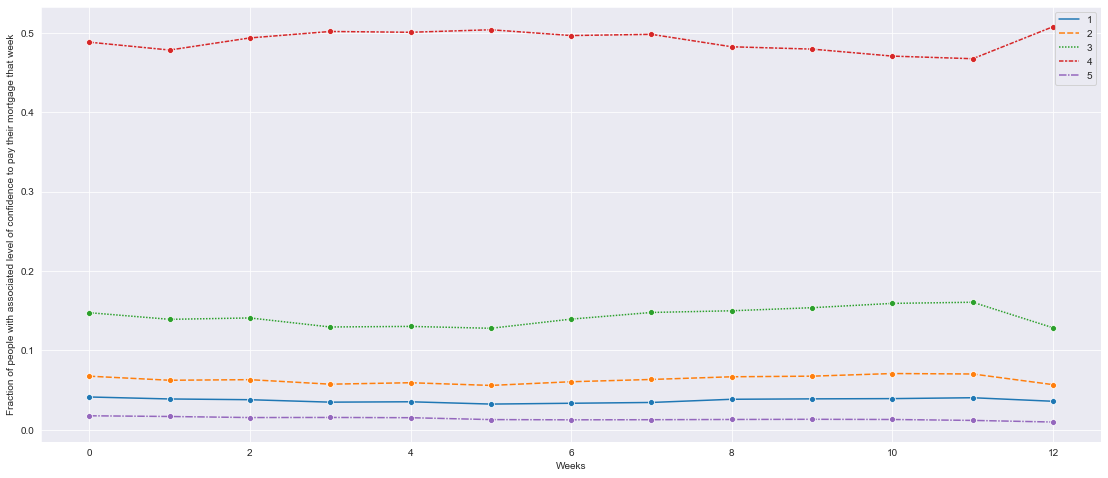

In [267]:
sns.lineplot(data=mortconf_df_week.iloc[:, :-1], marker = "o")
plt.xlabel("Weeks")
plt.ylabel("Fraction of people with associated level of confidence to pay their mortgage that week")
plt.legend()

In [276]:
data[['MORTCONF', 'ANXIETY_SCORE', 'DEPRESSION_SCORE']].corr()

,MORTCONF,ANXIETY_SCORE,DEPRESSION_SCORE
MORTCONF,1.000000,0.452491,0.451607
ANXIETY_SCORE,0.452491,1.000000,0.987449
DEPRESSION_SCORE,0.451607,0.987449,1.000000


### Employment

#### Workloss

In [284]:
wrkloss_df = pd.DataFrame(data.groupby(['WEEK', 'WRKLOSS'])['WRKLOSS'].count())
wrkloss_df.columns = ['WRKLOSS_count']
wrkloss_df = wrkloss_df.reset_index()

In [326]:
def get_week_df(df, col):
    df_dict = {str(i):df.loc[df[col] == i, col+'_count'].values for i in range(1, len(df[col].unique()))}
    df_dict['Week'] = np.arange(1, df['WEEK'].unique().max() + 1)
    df_week = pd.DataFrame(df_dict)
    for i in range(len(df_week)):
        df_week.iloc[i, :-1] = df_week.iloc[i, :-1]/total_num[i]
    return df_week

In [327]:
wrkloss_df_week = get_week_df(wrkloss_df, 'WRKLOSS')

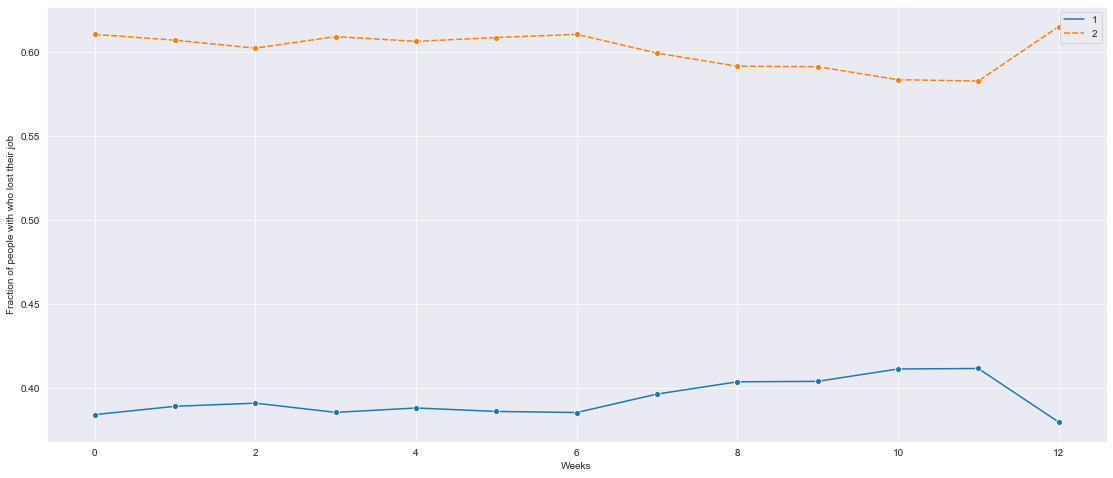

In [333]:
sns.lineplot(data=wrkloss_df_week.iloc[:, :-1], marker = "o")
plt.xlabel("Weeks")
plt.ylabel("Fraction of people with who lost their job")
plt.legend()

As we can see, on week 11, there were more people who didn't lose their job and less of those who did.

In [341]:
## TODO: add a description of what happened on week 11. 

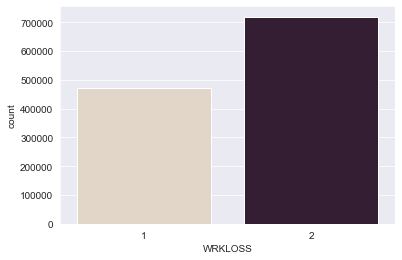

In [363]:
rcParams['figure.figsize'] = 6,4

sns.countplot(x='WRKLOSS', data=data[data['WRKLOSS'] != -99], palette="ch:.25")

In [342]:
data[['WRKLOSS', 'ANXIETY_SCORE', 'DEPRESSION_SCORE']].corr()

,WRKLOSS,ANXIETY_SCORE,DEPRESSION_SCORE
WRKLOSS,1.000000,0.186289,0.185781
ANXIETY_SCORE,0.186289,1.000000,0.987449
DEPRESSION_SCORE,0.185781,0.987449,1.000000


#### Any work 

In [358]:
anywork_un = data['ANYWORK'].unique()[(data['ANYWORK'].unique() != -99) & (data['ANYWORK'].unique() != -88)]

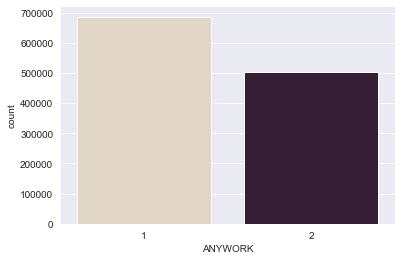

In [364]:
rcParams['figure.figsize'] = 6,4

sns.countplot(x='ANYWORK', data=data[data['ANYWORK'].isin(anywork_un)], palette="ch:.25")

In [365]:
data[['ANYWORK', 'ANXIETY_SCORE', 'DEPRESSION_SCORE']].corr()

,ANYWORK,ANXIETY_SCORE,DEPRESSION_SCORE
ANYWORK,1.000000,0.198077,0.198692
ANXIETY_SCORE,0.198077,1.000000,0.987449
DEPRESSION_SCORE,0.198692,0.987449,1.000000
